In [24]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer 
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
#reading the data
df_attractions=pd.read_csv("Attractions.csv")
df_attractions.head()

,ID,Name,Description,Open Timings,Location,Category,Rating,Review Count
0,1,Toronto Island Park,"Toronto's outdoor haven: bike trails, picnics ...",10:00 AM - 5:00 PM,Toronto,"Islands, Parks",4.5,8564
1,2,Canadian Warplane Heritage Museum,Canadian Warplane Heritage Museum features an ...,9:00 AM - 5:00 PM,Hamilton,Speciality Museums,4.5,1119
2,3,Jungle Cat World Wildlife Park,Jungle Cat World Wildlife Park is a wildlife s...,10:00 AM - 5:00 PM,Orono,"Nature and Wildlife Areas, Zoos",4.5,1081
3,4,The Grotto,The Grotto is a natural sea cave located withi...,NaN,Tobermory,"Points of Interest, Landmarks",4.5,1261
4,5,Canada Aviation and Space museum,Located on a former military air base just 5 k...,10:00 AM - 5:00 PM,Ottawa,Speciality Museums,4.5,1454


## Exploratory Data Analysis


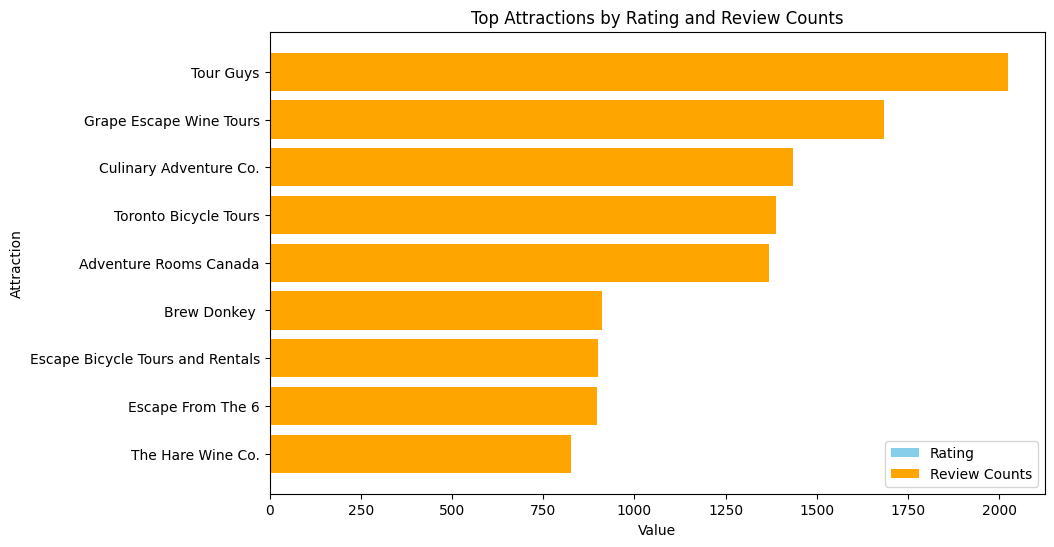

In [26]:
# Get top attractions by both rating and review counts
top_attractions_combined = df_attractions.sort_values(by=['Rating', 'Review Count'], ascending=[False, False]).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_attractions_combined['Name'], top_attractions_combined['Rating'], color='skyblue', label='Rating')
plt.barh(top_attractions_combined['Name'], top_attractions_combined['Review Count'], color='orange', label='Review Counts')
plt.xlabel('Value')
plt.ylabel('Attraction')
plt.title('Top Attractions by Rating and Review Counts')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis to display top attractions at the top
plt.show()


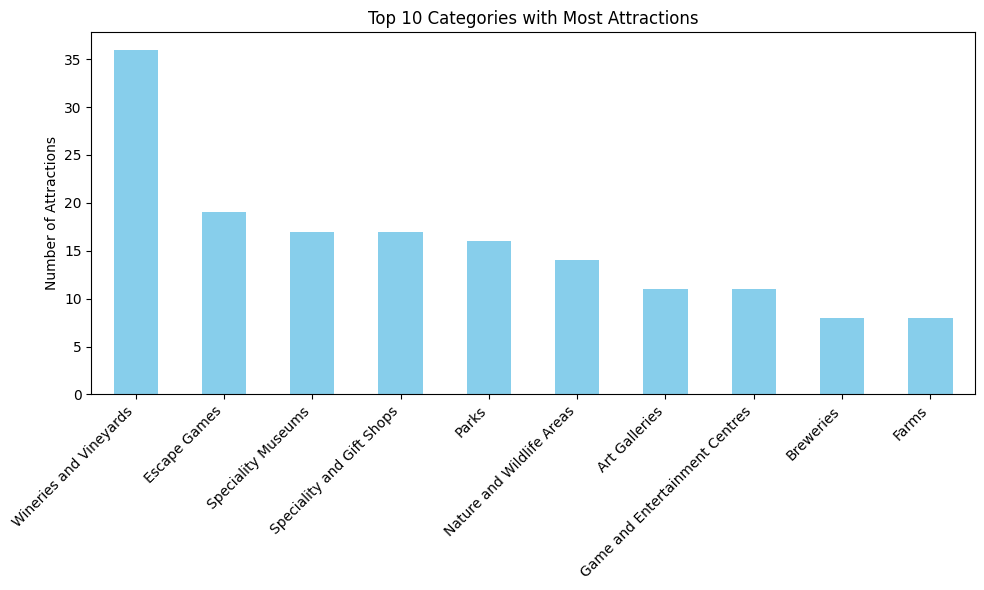

In [27]:
# Group attractions by category and count the number of attractions in each category
category_counts = df_attractions['Category'].value_counts()

# Sort the categories based on the number of attractions in descending order and select the top 10
top_categories = category_counts.head(10)

# Plot the top 10 categories
plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar', color='skyblue')
plt.title('Top 10 Categories with Most Attractions')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

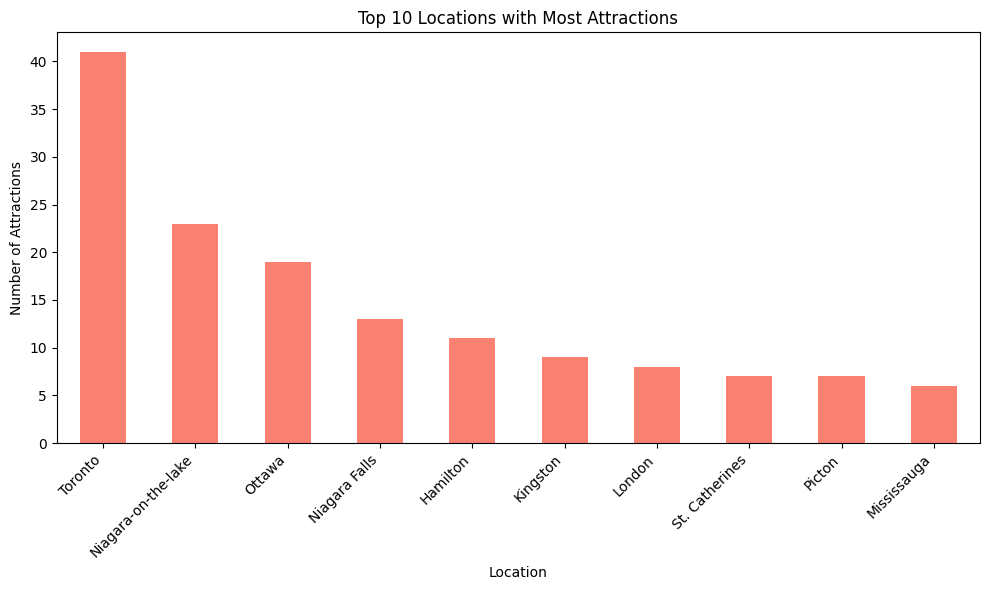

In [28]:
# Group attractions by location and count the number of attractions in each location
location_counts = df_attractions['Location'].value_counts()

# Sort the locations based on the number of attractions in descending order and select the top 10
top_locations = location_counts.head(10)

# Plot the top 10 locations
plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar', color='salmon')
plt.title('Top 10 Locations with Most Attractions')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

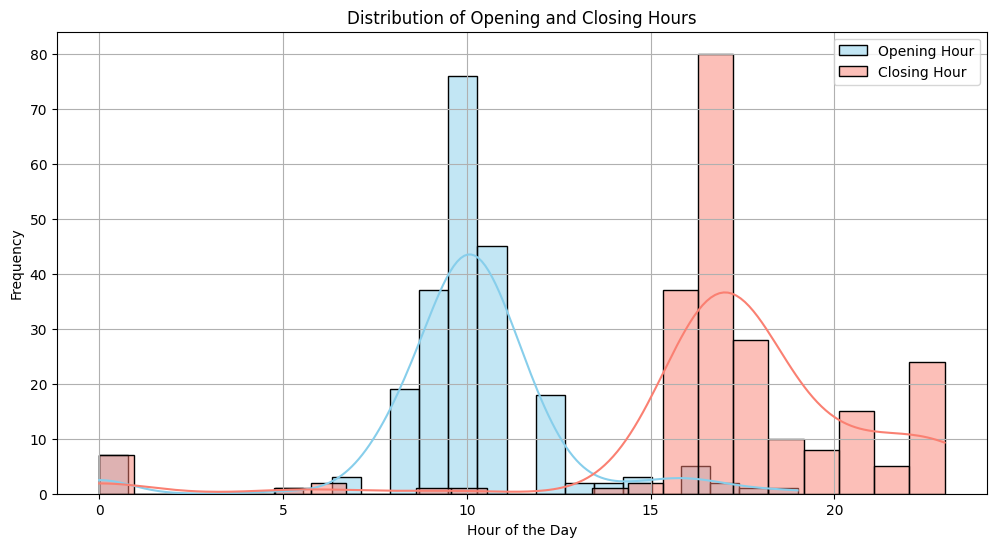

In [29]:

# Filter out rows with 'Temporarily closed' values
filtered_df = df_attractions[df_attractions['Open Timings'] != 'Temporarily Closed']

# Split the remaining strings into opening and closing hours
open_close = filtered_df['Open Timings'].str.split(' - ', expand=True)

# Convert opening and closing hours to datetime format
filtered_df['Opening Hour'] = pd.to_datetime(open_close[0], format='%I:%M %p', errors='coerce').dt.time
filtered_df['Closing Hour'] = pd.to_datetime(open_close[1], format='%I:%M %p', errors='coerce').dt.time

# Drop rows with missing opening or closing hours
filtered_df.dropna(subset=['Opening Hour', 'Closing Hour'], inplace=True)

# Extract hour of the day for opening and closing times
filtered_df['Opening Hour'] = filtered_df['Opening Hour'].apply(lambda x: x.hour)
filtered_df['Closing Hour'] = filtered_df['Closing Hour'].apply(lambda x: x.hour)

# Plot the distribution of opening and closing hours
plt.figure(figsize=(12, 6))
sns.histplot(filtered_df['Opening Hour'], bins=24, color='skyblue', kde=True, label='Opening Hour')
sns.histplot(filtered_df['Closing Hour'], bins=24, color='salmon', kde=True, label='Closing Hour')
plt.title('Distribution of Opening and Closing Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## Data Cleaning

In [30]:
#describe attractions dataframe
df_attractions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            413 non-null    int64  
 1   Name          413 non-null    object 
 2   Description   413 non-null    object 
 3   Open Timings  240 non-null    object 
 4   Location      413 non-null    object 
 5   Category      413 non-null    object 
 6   Rating        413 non-null    float64
 7   Review Count  413 non-null    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 25.9+ KB


In [31]:
#Checking for null values
df_attractions.isnull().sum()

ID                0
Name              0
Description       0
Open Timings    173
Location          0
Category          0
Rating            0
Review Count      0
dtype: int64

In [32]:
#preprocess Attractions data 
#Dropping irrevelant columns
columns_to_drop=['Open Timings']

df_attractions=df_attractions.drop(columns=columns_to_drop)
df_attractions

,ID,Name,Description,Location,Category,Rating,Review Count
0,1,Toronto Island Park,"Toronto's outdoor haven: bike trails, picnics ...",Toronto,"Islands, Parks",4.5,8564
1,2,Canadian Warplane Heritage Museum,Canadian Warplane Heritage Museum features an ...,Hamilton,Speciality Museums,4.5,1119
2,3,Jungle Cat World Wildlife Park,Jungle Cat World Wildlife Park is a wildlife s...,Orono,"Nature and Wildlife Areas, Zoos",4.5,1081
3,4,The Grotto,The Grotto is a natural sea cave located withi...,Tobermory,"Points of Interest, Landmarks",4.5,1261
4,5,Canada Aviation and Space museum,Located on a former military air base just 5 k...,Ottawa,Speciality Museums,4.5,1454
...,...,...,...,...,...,...,...
408,409,Red Apple Rides,Book an AMAZING guided bike tour or simply ren...,Port Dover,"Historical and Heritage Tours, Bike Tours, Sig...",5.0,32
409,410,Ottawa Biplane Adventures,We offer a bird's-eye view of Ottawa's most be...,Ottawa,Air Tours,4.5,37
410,411,Tours of the 6,Step into Toronto with this 2.5 hour walking t...,Toronto,"City Tours, Walking Tours",5.0,25
411,412,Deep Roots Adventure,Deep Roots Adventure is an Outdoor Adventure b...,Harcourt,"Multi-day Tours, Self-Guided Tours and Rentals...",5.0,16


## Feature Engineering


In [33]:
# Convert text in Description to lowercase
df_attractions['Description'] = df_attractions['Description'].str.lower()

# Remove punctuation
df_attractions['Description'] = df_attractions['Description'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Tokenize the text
df_attractions['Description'] = df_attractions['Description'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df_attractions['Description'] = df_attractions['Description'].apply(lambda x: [word for word in x if word not in stop_words])
df_attractions['Description'].head()

0    [torontos, outdoor, bike, trails, picnics, sky...
1    [canadian, warplane, heritage, museum, feature...
2    [jungle, cat, world, wildlife, park, wildlife,...
3    [grotto, natural, sea, cave, located, within, ...
4    [located, former, military, air, base, 5, kilo...
Name: Description, dtype: object

In [34]:
# Convert tokenized lists back into strings
df_attractions['Description'] = df_attractions['Description'].apply(lambda x: ' '.join(x))
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the description column to TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(df_attractions['Description'])

# Convert TF-IDF vectors to a DataFrame
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF DataFrame
#tfidf_df

In [35]:
from scipy.sparse import hstack
# Split categories and convert them into lists of strings
categories = df_attractions['Category'].str.split(', ')

# Initialize multi-label binarizer for categories
mlb = MultiLabelBinarizer()

# Fit and transform the split categories to one-hot encoded matrix
category_matrix = mlb.fit_transform(categories)

# Initialize one-hot encoder for locations
encoder = OneHotEncoder()

# Fit and transform the location column to one-hot encoded matrix
location_matrix = encoder.fit_transform(df_attractions[['Location']])

# Concatenate TF-IDF matrix, category matrix, and location matrix into a single features matrix
features_matrix = hstack([tfidf_df, category_matrix, location_matrix])
#print(features_matrix)

# Compute cosine similarity between attractions based on the features matrix
similarity_scores = cosine_similarity(features_matrix)
#print(similarity_scores)


In [36]:
# Check the dimensions of the features matrix
print("Features matrix dimensions:", features_matrix.shape)

Features matrix dimensions: (413, 5251)


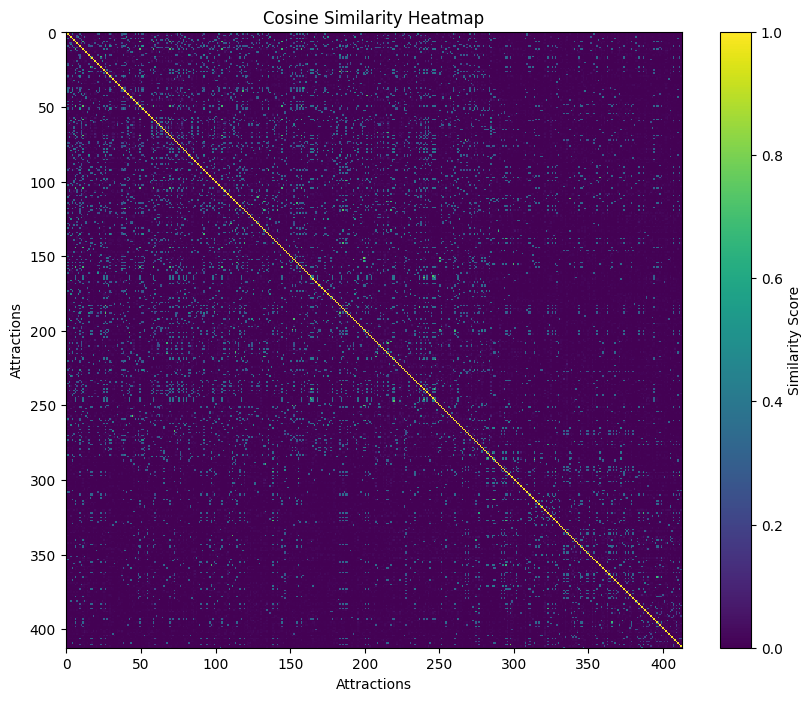

In [37]:
import matplotlib.pyplot as plt

def plot_similarity_heatmap(similarity_scores):
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_scores, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Similarity Score')
    plt.title('Cosine Similarity Heatmap')
    plt.xlabel('Attractions')
    plt.ylabel('Attractions')
    plt.show()


plot_similarity_heatmap(similarity_scores)

## Model

In [38]:
def recommend(attraction):
    try:
        # Find the index of the attraction with the specified name
        attraction_index = df_attractions[df_attractions['Name'] == attraction].index[0]
        
        # Retrieve the similarity scores for the attraction
        distances = similarity_scores[attraction_index]
        
        # Sort attractions based on similarity scores
        attractions_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:4]
        
        # Print information for each similar attraction
        for i in attractions_list:
            print(df_attractions.iloc[i[0]])
            print("-" * 70)
    except IndexError:
        print("Attraction '{}' not found.".format(attraction))


## Feature 1.

### Recommending Places based on User's Preferred Attraction.

Example 1.

In [39]:
#Recommending places similar to King's Wharf Theatre
recommend("King's Wharf Theatre")

ID                                                            217
Name                                             4th Line Theater
Description     located millbrook ontario 4th line theater pro...
Location                                                Millbrook
Category                                                 Theatres
Rating                                                        4.0
Review Count                                                   59
Name: 216, dtype: object
----------------------------------------------------------------------
ID                                                            146
Name                                       Upper Canada Playhouse
Description     upper canada playhouse established 1983 nonpro...
Location                                               Morrisburg
Category                                                 Theatres
Rating                                                        4.5
Review Count                                  

Example 2.

In [40]:
#Recommending places similar to Niagara Glen Nature Areas
recommend('Niagara Glen Nature Areas')

ID                                                             42
Name                                        Dufferin Islands Park
Description     dufferin islands park nestled niagara falls bo...
Location                                            Niagara Falls
Category                                           Islands, Parks
Rating                                                        4.5
Review Count                                                  376
Name: 41, dtype: object
----------------------------------------------------------------------
ID                                                            241
Name                                 Aubrey Falls Provincial Park
Description     aubrey falls provincial park remote wilderness...
Location                                                Thessalon
Category                         Nature and Wildlife Areas, Parks
Rating                                                        4.5
Review Count                                   

## Feature 2.

### Recommending Top places to Visit based on User's Preferred Location

In [41]:
def top_attractions_by_location(location):
    try:
        # Filter attractions by the specified location
        attractions_in_location = df_attractions[df_attractions['Location'] == location]
        
        # Sort attractions by ratings and review count
        top_attractions = attractions_in_location.sort_values(by=['Rating', 'Review Count'], ascending=False).head(5)
        
        return top_attractions
    except KeyError:
        print("Location '{}' not found in the dataset.".format(location))




Example 1.

In [42]:
top_attractions_by_location('Toronto')

,ID,Name,Description,Location,Category,Rating,Review Count
297,298,Tour Guys,tour guys began operating free tipwhatyoufeel ...,Toronto,"City Tours, Walking Tours",5.0,2023
276,277,Culinary Adventure Co.,torontos premier food tour company since 2011 ...,Toronto,"Private Tours, Food Tours",5.0,1434
295,296,Toronto Bicycle Tours,take ride toronto bicycle tours ’ fantastic fu...,Toronto,"City Tours, Bike Tours",5.0,1389
94,95,Famous People Players Dinner Theatre,group mounts unique visually fantastic black l...,Toronto,Dinner Theatres,5.0,662
310,311,Chpsticks+Forks,designed explorer “ round world ” food experie...,Toronto,Historical and Heritage Tours,5.0,621


Example 2.

In [43]:
top_attractions_by_location('Tobermory')

,ID,Name,Description,Location,Category,Rating,Review Count
381,382,Eco Adventures Bruce Peninsula,ecoadventures offers guided excursions wanting...,Tobermory,Nature and Wildlife Tours,5.0,82
3,4,The Grotto,grotto natural sea cave located within bruce p...,Tobermory,"Points of Interest, Landmarks",4.5,1261
7,8,Bruce Peninsula National Park,visiting bruce peninsula national park start a...,Tobermory,"National Parks, Nature and Wildlife Areas, Hiking",4.5,762
12,13,Flowerpot Island,trip flowerpot island great way experience fat...,Tobermory,Islands,4.5,726
101,102,Cyprus LakeCyprus Lake,scenic lake located bruce peninsula national p...,Tobermory,Bodies of Water,4.5,135


## Feature 3.

### Recommending Top places to visit based User's Preferred Category

In [44]:
def top_attractions_by_category(category):
    try:
        # Filter attractions by the specified category
        attractions_in_category = df_attractions[df_attractions['Category'] == category]
        
        # Sort attractions by ratings and review count
        top_attractions = attractions_in_category.sort_values(by=['Rating', 'Review Count'], ascending=False).head(5)
        
        return top_attractions
    except KeyError:
        print("Category '{}' not found in the dataset.".format(category))

Example 1.

In [45]:
top_attractions_by_category('Parks')

,ID,Name,Description,Location,Category,Rating,Review Count
64,65,Stewart Park,stewart park nestled heart perth ontario offer...,Perth,Parks,5.0,183
5,6,Sandbanks Provincial Park,sandbanks provincial park one busiest parks pr...,Picton,Parks,4.5,1458
60,61,Awenda Provincial Park,awenda provincial park situated shores georgia...,Penetanguishene,Parks,4.5,300
68,69,Bon Echo Provincial Park,bon echo provincial park nestled along shores ...,Cloyne,Parks,4.5,295
84,85,Crawford Lake Conservation Area,crawford lake conservation area located milton...,Campbellville,Parks,4.5,263


Example 2.

In [46]:
top_attractions_by_category('Historic Sites') 

,ID,Name,Description,Location,Category,Rating,Review Count
83,84,Bellevue House National Historic Site,rare fine example canada italianate villa arch...,Kingston,Historic Sites,4.5,336
73,74,Fanshawe Pioneer Village,fanshawe pioneer village offers captivating gl...,London,Historic Sites,4.5,222
87,88,Willistead Manor,willistead manor elegant historic mansion loca...,Windsor,Historic Sites,4.5,98
161,162,Whitehern Historic House and Garden,elegant museum heart downtown widely considere...,Hamilton,Historic Sites,4.5,59
228,229,Annandale National Historic Site,annandale national historic site historic home...,Tillsonburg,Historic Sites,4.5,42
